In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal

plt.style.use('ggplot')

## Probablistic PCA with Shared Latent Variables but different weights

In [2]:
def build_toy_dataset(N, D, K, sigma=1):
    
  z = np.random.normal(0.0, 1.0, size=(K, N))
  x_train1 = np.zeros((D, N))
  w1 = np.random.normal(0.0, 2.0, size=(D, K))
  mean1 = np.dot(w1, z)
  for d in range(D):
    for n in range(N):
      x_train1[d, n] = np.random.normal(mean1[d, n], sigma)

  x_train2 = np.zeros((D, N))
  w2 = np.random.normal(0.0, 5.0, size=(D, K))
  mean2 = np.dot(w2, z)
  for d in range(D):
    for n in range(N):
      x_train2[d, n] = np.random.normal(mean2[d, n], sigma)
      
  print("True principal axes for train1:")
  print(w1)
  print("True principal axes for train2:")
  print(w2)
  return x_train1, x_train2, z

#ed.set_seed(140)

N = 50  # number of data points
D = 2     # data dimensionality
K = 1     # latent dimensionality

x_train1, x_train2, z_true = build_toy_dataset(N, D, K)

True principal axes for train1:
[[-0.37270672]
 [ 2.19418558]]
True principal axes for train2:
[[ -1.84305931]
 [ 10.85952461]]


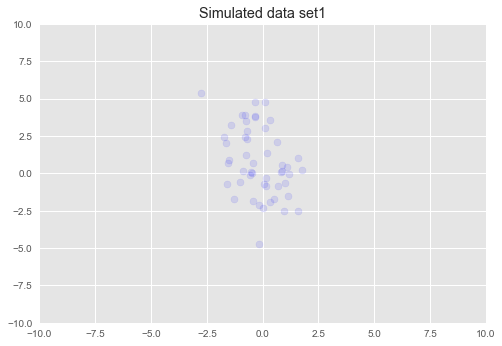

In [3]:
plt.scatter(x_train1[0, :], x_train1[1, :], color='blue', alpha=0.1)
plt.axis([-10, 10, -10, 10])
plt.title("Simulated data set1")
plt.show()

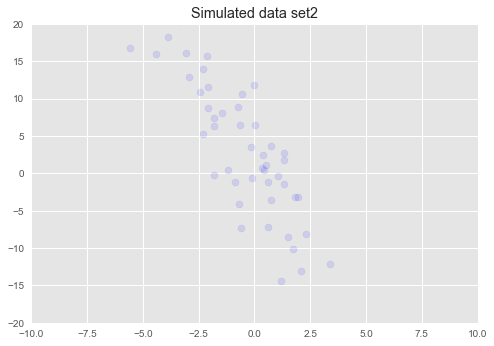

In [4]:
plt.scatter(x_train2[0, :], x_train2[1, :], color='blue', alpha=0.1)
plt.axis([-10, 10, -20, 20])
plt.title("Simulated data set2")
plt.show()

In [8]:
w1 = Normal(loc=tf.zeros([D, K]), scale=2.0 * tf.ones([D, K]))
w2 = Normal(loc=tf.zeros([D, K]), scale=5.0 * tf.ones([D, K]))
z = Normal(loc=tf.zeros([N, K]), scale=tf.ones([N, K]))
x1 = Normal(loc=tf.matmul(w1, z, transpose_b=True), scale=tf.ones([D, N]))
x2 = Normal(loc=tf.matmul(w2, z, transpose_b=True), scale=tf.ones([D, N]))

<tf.Tensor 'ones_15:0' shape=(2, 50) dtype=float32>

In [6]:
qw1 = Normal(loc=tf.Variable(tf.random_normal([D, K])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))

qw2 = Normal(loc=tf.Variable(tf.random_normal([D, K])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))

qz = Normal(loc=tf.Variable(tf.random_normal([N, K])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([N, K]))))

inference = ed.KLqp({w1: qw1, w2: qw2, z: qz}, data={x1: x_train1, x2: x_train2})
inference.run(n_iter=50, n_print=10, n_samples=10)

50/50 [100%] ██████████████████████████████ Elapsed: 2s | Loss: 798.422


<tf.Variable 'Variable_6:0' shape=(2, 1) dtype=float32_ref>

# Two princple axes are consistent with the true axes

In [16]:
sess = ed.get_session()
print("Inferred principal axes 1:")
print(sess.run(qw1.mean()))
print("Inferred principal axes 2:")
print(sess.run(qw2.mean()))

Inferred principal axes 1:
[[ 0.50811529]
 [-1.19713259]]
Inferred principal axes 2:
[[ 4.32508755]
 [-3.19738126]]


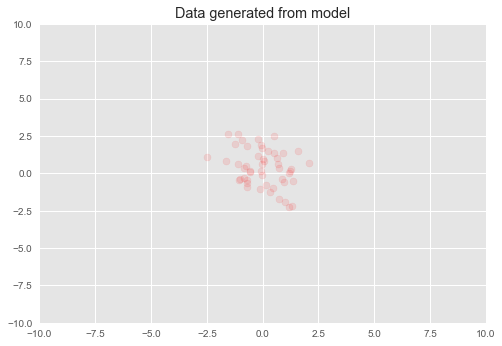

In [8]:
x_post = ed.copy(x1, {w1: qw1, z: qz})
x_gen = sess.run(x_post)

plt.scatter(x_gen[0, :], x_gen[1, :], color='red', alpha=0.1)
plt.axis([-10, 10, -10, 10])
plt.title("Data generated from model")
plt.show()

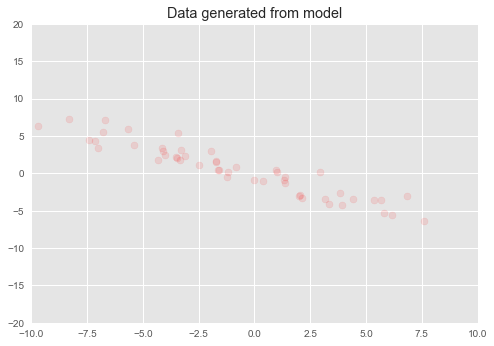

In [9]:
x_post = ed.copy(x2, {w2: qw2, z: qz})
x_gen = sess.run(x_post)

plt.scatter(x_gen[0, :], x_gen[1, :], color='red', alpha=0.1)
plt.axis([-10, 10, -20, 20])
plt.title("Data generated from model")
plt.show()

In [10]:
qz_samples = np.mean(qz.sample(100).eval(),0)

# Plot true and estimated latent variables

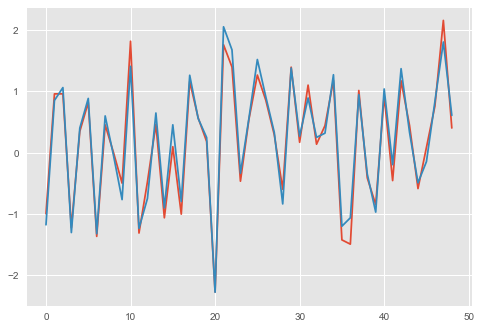

In [14]:
plt.plot(qz_samples[1:100,])
plt.plot(z_true[0,1:100].transpose())
plt.show()

# Only one dataset for latent variable recovery

In [12]:
qw2 = Normal(loc=tf.Variable(tf.random_normal([D, K])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))

qz = Normal(loc=tf.Variable(tf.random_normal([N, K])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([N, K]))))

inference = ed.KLqp({w2: qw2, z: qz}, data={x2: x_train2})
inference.run(n_iter=500, n_print=100, n_samples=10)

500/500 [100%] ██████████████████████████████ Elapsed: 3s | Loss: 225.153


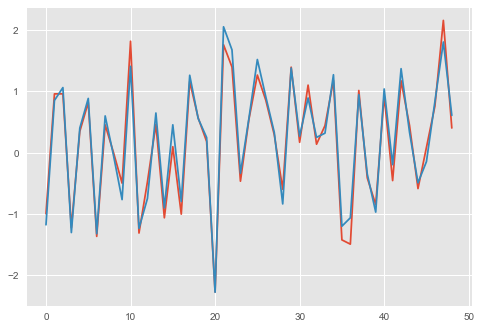

In [13]:
qz_samples = np.mean(qz.sample(100).eval(),0)
plt.plot(qz_samples[1:100,])
plt.plot(z_true[0,1:100].transpose())
plt.show()